In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read the train and test datasets

In [2]:
x_train = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/x_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/x_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/y_test.csv')

In [3]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      730 non-null    int64
 1   sex         730 non-null    int64
 2   age         730 non-null    int64
 3   address     730 non-null    int64
 4   famsize     730 non-null    int64
 5   Pstatus     730 non-null    int64
 6   Medu        730 non-null    int64
 7   Fedu        730 non-null    int64
 8   Mjob        730 non-null    int64
 9   Fjob        730 non-null    int64
 10  reason      730 non-null    int64
 11  guardian    730 non-null    int64
 12  traveltime  730 non-null    int64
 13  studytime   730 non-null    int64
 14  failures    730 non-null    int64
 15  schoolsup   730 non-null    int64
 16  famsup      730 non-null    int64
 17  paid        730 non-null    int64
 18  activities  730 non-null    int64
 19  nursery     730 non-null    int64
 20  higher      730 non-null    int6

In [4]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      314 non-null    int64
 1   sex         314 non-null    int64
 2   age         314 non-null    int64
 3   address     314 non-null    int64
 4   famsize     314 non-null    int64
 5   Pstatus     314 non-null    int64
 6   Medu        314 non-null    int64
 7   Fedu        314 non-null    int64
 8   Mjob        314 non-null    int64
 9   Fjob        314 non-null    int64
 10  reason      314 non-null    int64
 11  guardian    314 non-null    int64
 12  traveltime  314 non-null    int64
 13  studytime   314 non-null    int64
 14  failures    314 non-null    int64
 15  schoolsup   314 non-null    int64
 16  famsup      314 non-null    int64
 17  paid        314 non-null    int64
 18  activities  314 non-null    int64
 19  nursery     314 non-null    int64
 20  higher      314 non-null    int6

In [5]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   G3      730 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB


In [6]:
y_test.head(n = 5)

,G3
0,11
1,8
2,13
3,11
4,12


## Split into numerical and categorical variables

In [7]:
num_cols = ['age','absences','G1','G2']
x_train_numerical = x_train[num_cols]

# get the names of the numerical columns
cat_cols = list(set(x_train.columns) - set(x_train_numerical.columns))
x_train_cat = x_train[cat_cols]

## Feature Selection

Getter function for mutual information (numerical variables)

In [8]:
from sklearn.feature_selection import mutual_info_regression

def mutual_info_df(x_train_variable, y_train, variable_type):
  # Compute mutual information between each feature in X and y
  mutual_info = mutual_info_regression(x_train_variable, y_train, random_state=42)

  # Create a DataFrame to store the mutual information scores for each feature
  mi_df = pd.DataFrame({'feature': variable_type, 'mi_score': mutual_info})

  # Sort the features by their mutual information scores in descending order
  mi_df = mi_df.sort_values(by='mi_score', ascending=False)

  # REturn the mutual information scores for each feature
  return mi_df

Getter function for iterative mutual information

In [9]:
def iterative_mi_final_df(x_train, y_train):
  archive_train = x_train
  master_cols = x_train.columns
  cols_to_drop = []
  final_mf = mutual_info_df(archive_train, y_train, archive_train.columns)
  # Filter out for 0 mutual information feature
  zero_mi_df = final_mf[final_mf["mi_score"] == 0]
  zero_cat = list(zero_mi_df["feature"])
  # print(zero_cat)
  cols_to_drop.extend(zero_cat)
  archive_train = archive_train.drop(zero_cat, axis = 1)
  # print("Ok")
  # Stopping criteria is there should not be any more 0 mutual information feature
  while len(zero_cat) !=0:
    temp_mf = mutual_info_df(archive_train, y_train, archive_train.columns)
    zero_mi_df = temp_mf[temp_mf["mi_score"] == 0]
    zero_cat = list(zero_mi_df["feature"])
    cols_to_drop.extend(zero_cat)
    archive_train = archive_train.drop(zero_cat, axis = 1)

  return temp_mf, cols_to_drop

#### Numerical variables

Check for the collinearity

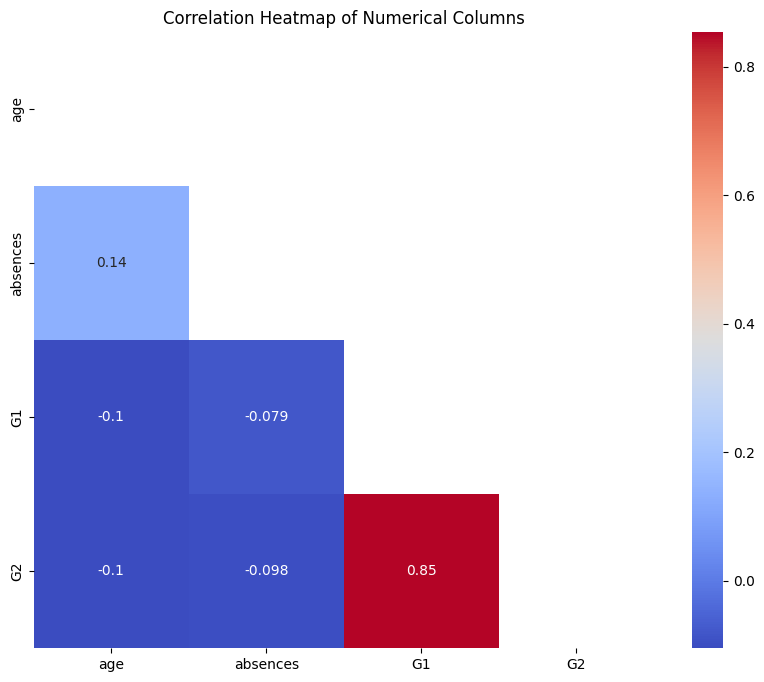

In [10]:
# Assuming x_train_numerical contains the numerical columns
correlation_matrix = x_train_numerical.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the lower triangle collinear heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

Combine G1 and G2 score together to form a new column

In [11]:
# Assuming 'df' is your DataFrame containing G1 and G2 columns
x_train['G1_G2_sum'] = (x_train['G1'] + x_train['G2']) / 2
# Drop the G1 and G2 columns from the dataframe
x_train = x_train.drop(['G1', 'G2'], axis=1)

# Assuming 'df' is your DataFrame containing G1 and G2 columns
x_test['G1_G2_sum'] = (x_test['G1'] + x_test['G2']) / 2
# Drop the G1 and G2 columns from the dataframe
x_test = x_test.drop(['G1', 'G2'], axis=1) 

In [12]:
x_train_numerical['G1_G2_sum'] = (x_train_numerical['G1'] + x_train_numerical['G2']) / 2
x_train_numerical = x_train_numerical.drop(['G1', 'G2'], axis=1)

<ipython-input-12-f1c4115da229>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_numerical['G1_G2_sum'] = (x_train_numerical['G1'] + x_train_numerical['G2']) / 2


Note that the other columns take on values of 0 and 1, we need to use min max scaler to normalise the `G1_G2_sum` and `absences` columns

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the 'G1_G2_sum' column
x_train['G1_G2_sum_normalized'] = scaler.fit_transform(x_train[['G1_G2_sum']])
x_test['G1_G2_sum_normalized'] = scaler.fit_transform(x_test[['G1_G2_sum']])
x_train_numerical['G1_G2_sum_normalized'] = scaler.fit_transform(x_train_numerical[['G1_G2_sum']])

# Fit and transform the 'absences'
x_train['absences_normalized'] = scaler.fit_transform(x_train[['absences']])
x_test['absences_normalized'] = scaler.fit_transform(x_test[['absences']])
x_train_numerical['absences_normalized'] = scaler.fit_transform(x_train_numerical[['absences']])

Drop the G1_G2_sum column

In [14]:
x_train = x_train.drop('G1_G2_sum', axis=1)
x_test = x_test.drop('G1_G2_sum', axis=1)
x_train_numerical = x_train_numerical.drop('G1_G2_sum', axis=1)  

Drop the absences column

In [15]:
x_train = x_train.drop('absences', axis=1)
x_test = x_test.drop('absences', axis=1)
x_train_numerical = x_train_numerical.drop('absences', axis=1) 

In [16]:
x_train_numerical.head(n = 5)

,age,G1_G2_sum_normalized,absences_normalized
0,15,0.441176,0.053333
1,20,0.529412,0.106667
2,15,0.617647,0.000000
3,16,0.441176,0.106667
4,16,0.676471,0.000000


In [17]:
num_cols = ['age','G1_G2_sum_normalized','absences_normalized']

Mutual information gain

In [18]:
mf1 = mutual_info_df(x_train_numerical, y_train, num_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
mf1

,feature,mi_score
1,G1_G2_sum_normalized,1.185251
2,absences_normalized,0.068090
0,age,0.013303


#### All categorical and numerical variables together

###### Mutual information

In [20]:
final_mf, cols_to_drop = iterative_mi_final_df(x_train, y_train["G3"])

In [21]:
final_mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 9 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature   11 non-null     object 
 1   mi_score  11 non-null     float64
dtypes: float64(1), object(1)
memory usage: 264.0+ bytes


In [22]:
final_mf

,feature,mi_score
9,G1_G2_sum_normalized,1.216715
6,failures,0.099691
7,higher,0.052787
10,absences_normalized,0.049222
2,Medu,0.046477
8,subject,0.045831
3,Fedu,0.035484
5,studytime,0.030810
4,Mjob,0.019772
1,address,0.019536


In [23]:
cols_to_drop

['internet',
 'romantic',
 'activities',
 'paid',
 'Dalc',
 'Walc',
 'health',
 'guardian',
 'Pstatus',
 'famsup',
 'famrel',
 'freetime',
 'nursery',
 'school',
 'Fjob',
 'famsize',
 'sex',
 'traveltime',
 'reason',
 'schoolsup',
 'goout']

In [24]:
top_features = final_mf['feature'].tolist()

In [25]:
top_features

['G1_G2_sum_normalized',
 'failures',
 'higher',
 'absences_normalized',
 'Medu',
 'subject',
 'Fedu',
 'studytime',
 'Mjob',
 'address',
 'age']

Check the list for the cols to drop

In [26]:
len(cols_to_drop)

21

For the first dataset, drop these 21 columns due to 0 mi score.

In [27]:
x_train = x_train.drop(cols_to_drop, axis = 1)
x_test = x_test.drop(cols_to_drop, axis = 1)

In [28]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   730 non-null    int64  
 1   address               730 non-null    int64  
 2   Medu                  730 non-null    int64  
 3   Fedu                  730 non-null    int64  
 4   Mjob                  730 non-null    int64  
 5   studytime             730 non-null    int64  
 6   failures              730 non-null    int64  
 7   higher                730 non-null    int64  
 8   subject               730 non-null    int64  
 9   G1_G2_sum_normalized  730 non-null    float64
 10  absences_normalized   730 non-null    float64
dtypes: float64(2), int64(9)
memory usage: 62.9 KB


In [29]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   314 non-null    int64  
 1   address               314 non-null    int64  
 2   Medu                  314 non-null    int64  
 3   Fedu                  314 non-null    int64  
 4   Mjob                  314 non-null    int64  
 5   studytime             314 non-null    int64  
 6   failures              314 non-null    int64  
 7   higher                314 non-null    int64  
 8   subject               314 non-null    int64  
 9   G1_G2_sum_normalized  314 non-null    float64
 10  absences_normalized   314 non-null    float64
dtypes: float64(2), int64(9)
memory usage: 27.1 KB


## Export the dataset

In [30]:
import os

In [31]:
x_train.to_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/x_train_clean_11.csv', index = False)
x_test.to_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/x_test_clean_11.csv', index = False)